# Exploring the Maraston grids

In this notebook we will explore the Maraston grids and recreate plots from the paper Newman et al. 2024, "Cloudy-Maraston: Integrating nebular line and continuum emission with the M13 stellar population synthesis models". 

First import the relevant modules, including synthesizer:

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from synthesizer.grid import Grid
from matplotlib.lines import Line2D
from unyt import Angstrom, um
import cmasher as cmr 

# and set up plotting 

plt.rcParams['figure.dpi'] = 200
mpl.rcParams.update({'font.size': 12})
cmap = cmr.bubblegum

## Figure 1: Let's see what our Maraston model looks like!

We need to load the Maraston grid into synthesizer:

In [47]:
grid_dir = '../grids'
grid_name = 'maraston13_kroupa-max_age:7.0_cloudy-c23.01-sps'
grid = Grid(grid_name, grid_dir=grid_dir, read_lines=True)

# Print the grid to see its attributes if you like
# print(grid)

Now we can plot the spectra for a single metallicity and varying ages.

/home/sophienewman/.local/lib/python3.10/site-packages/unyt/array.py:1813: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


Text(0.5, 0, '$\\rm \\log_{10}(age/yr)$')

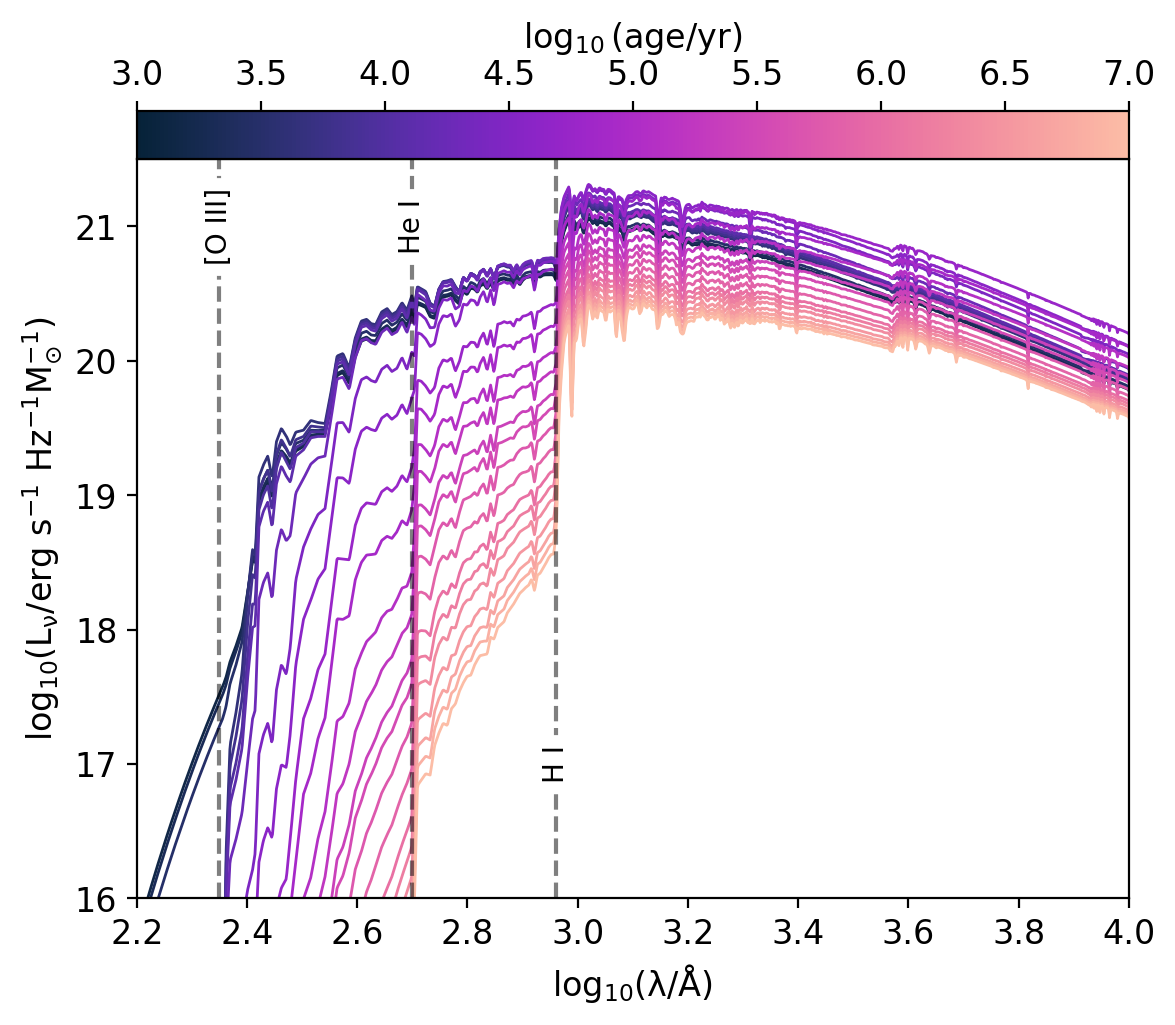

In [48]:
fig, ax = plt.subplots()
norm = mpl.colors.Normalize(vmin=min(log10ages), vmax=max(log10ages))
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

Z = 0.02 
log10ages = grid.log10age

#for each age:
m = 0
for log10age in log10ages: 
    m = m + 1
    grid_point = grid.get_grid_point((log10age,Z))
    #Loop over the available spectra and plot Maraston:
    for spectra_id in ["incident"]:
        # get Sed object
        sed = grid.get_spectra(grid_point, spectra_id=spectra_id)
        ax.plot(np.log10(sed.lam), np.log10(sed.lnu), 
                 lw=1, 
                 label=f'log10age = {round(log10age,1)}',
                 color = cmap(m/len(log10ages)))

plt.xlim(left=2.2, right=4)
plt.ylim(bottom=16, top=21.5)
plt.title(f'Z={Z}')
plt.xlabel(r'$\rm log_{10}(\lambda/\AA)$')
plt.ylabel(r'$\rm log_{10}(L_{\nu}/erg\ s^{-1}\ Hz^{-1} M_{\odot}^{-1})$')

# Show ionisation energies
plt.axvline(x=2.96, ymin=0, ymax=1, color='black', alpha= 0.5, linestyle='--') # H I
plt.axvline(x=2.70, ymin=0, ymax=1, color='black', alpha= 0.5, linestyle='--') # He I
plt.axvline(x=2.35, ymin=0, ymax=1, color='black', alpha= 0.5, linestyle='--') # [O III]

plt.text(x=2.96, y=17, s='H I', ha='center', va='center',rotation='vertical', backgroundcolor='white', fontsize = 10) # H I
plt.text(x=2.70, y=21, s='He I', ha='center', va='center',rotation='vertical', backgroundcolor='white', fontsize = 10) # He I
plt.text(x=2.35, y=21, s='[O III]', ha='center', va='center',rotation='vertical', backgroundcolor='white', fontsize = 10) # [O III]

# Create colorbar axis
left = 0.125
bottom = 0.8
width = 0.775
height = 0.08
cax = fig.add_axes([left, bottom + height, width, 0.05])  # [left, bottom, width, height]
cbar = plt.colorbar(sm, cax=cax, orientation='horizontal')
cax.xaxis.tick_top()
cax.xaxis.set_label_position("top")
cax.set_xlabel(r"$\rm \log_{10}(age/yr)$")

## Figure 2: Now lets compare the effect of changing the IMF

We need to load in our Kroupa and Salpeter grids:

In [49]:
grid_dir = '../grids'

grid_name = 'maraston13_kroupa-max_age:7.0'
grid_k = Grid(grid_name, grid_dir=grid_dir, read_lines=False)

grid_name = 'maraston13_salpeter-max_age:7.0'
grid_s = Grid(grid_name, grid_dir=grid_dir, read_lines=False)

And now we can plot the differences!

Text(0.5, 0, 'Metallicity, Z')

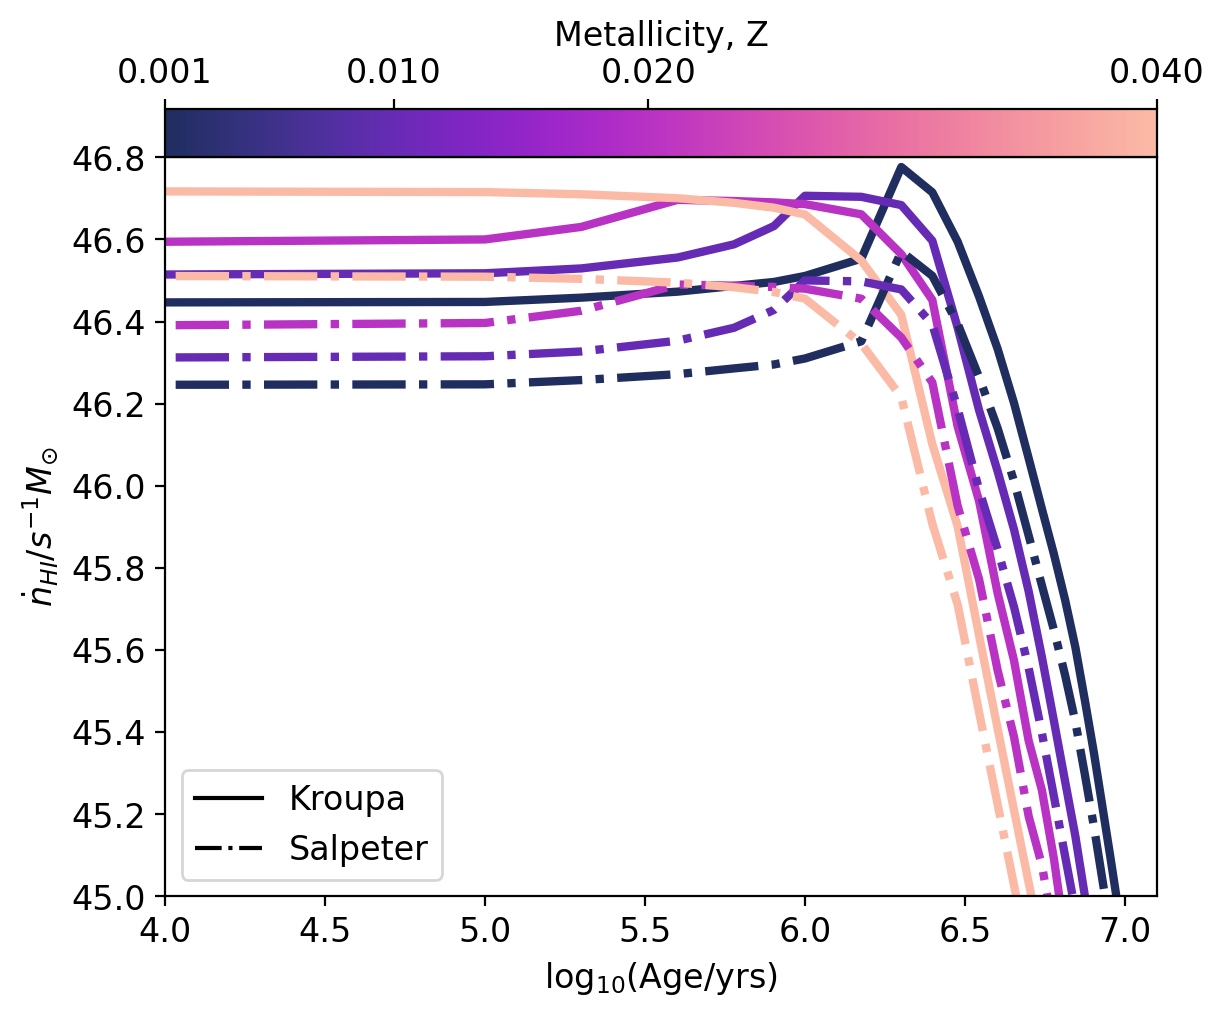

In [50]:
fig, ax = plt.subplots(figsize=(6.4, 4.8))
cmap = cmr.get_sub_cmap('cmr.bubblegum', 0.1, 0.99)
norm = mpl.colors.Normalize(vmin=min(metallicities), vmax=max(metallicities))
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

grids = [grid_k, grid_s]
imfs = ['Kroupa', 'Salpeter']

spectra_id = "incident"

Q = grid_k.log10_specific_ionising_lum['HI'] # for all Z
Q_k = Q.T # (4, 67)
for iZ, Z in enumerate(grid_k.metallicity):
    plt.plot(grid_k.log10age, Q_k[iZ,:], color = cmap(norm(Z)), lw=3, ls='-')

Q = grid_s.log10_specific_ionising_lum['HI'] # for all Z
Q_s = Q.T # (4, 67)
for iZ, Z in enumerate(grid_s.metallicity):
    plt.plot(grid_s.log10age, Q_s[iZ,:], color = cmap(norm(Z)), lw=3, ls='-.')

plt.xlabel('log$_{10}$(Age/yrs)')
plt.ylabel(r'$\dot{n}_{HI}/s^{-1}M_{\odot}$')
plt.ylim(bottom=45, top=46.8)
plt.xlim(left=4, right=7.1)

# Create legend
legend_elements = [Line2D([0, 1], [0, 1], linestyle='-', color='black', label='Kroupa'),
                   Line2D([0, 1], [0, 1], linestyle='-.', color='black', label='Salpeter')
]
plt.legend(handles=legend_elements, loc='lower left')

# Create colorbar axis
left = 0.125
bottom = 0.8
width = 0.775
height = 0.08
cax = fig.add_axes([left, bottom + height, width, 0.05])  # [left, bottom, width, height]
cbar = plt.colorbar(sm, cax=cax, orientation='horizontal')
cbar.set_ticks(grid_s.metallicity)
cax.xaxis.tick_top()
cax.xaxis.set_label_position("top")
cax.set_xlabel(r"Metallicity, Z")

## Figure 3: Plot the emission line components

/home/sophienewman/.local/lib/python3.10/site-packages/unyt/array.py:1813: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


(3000.0, 10000.0)

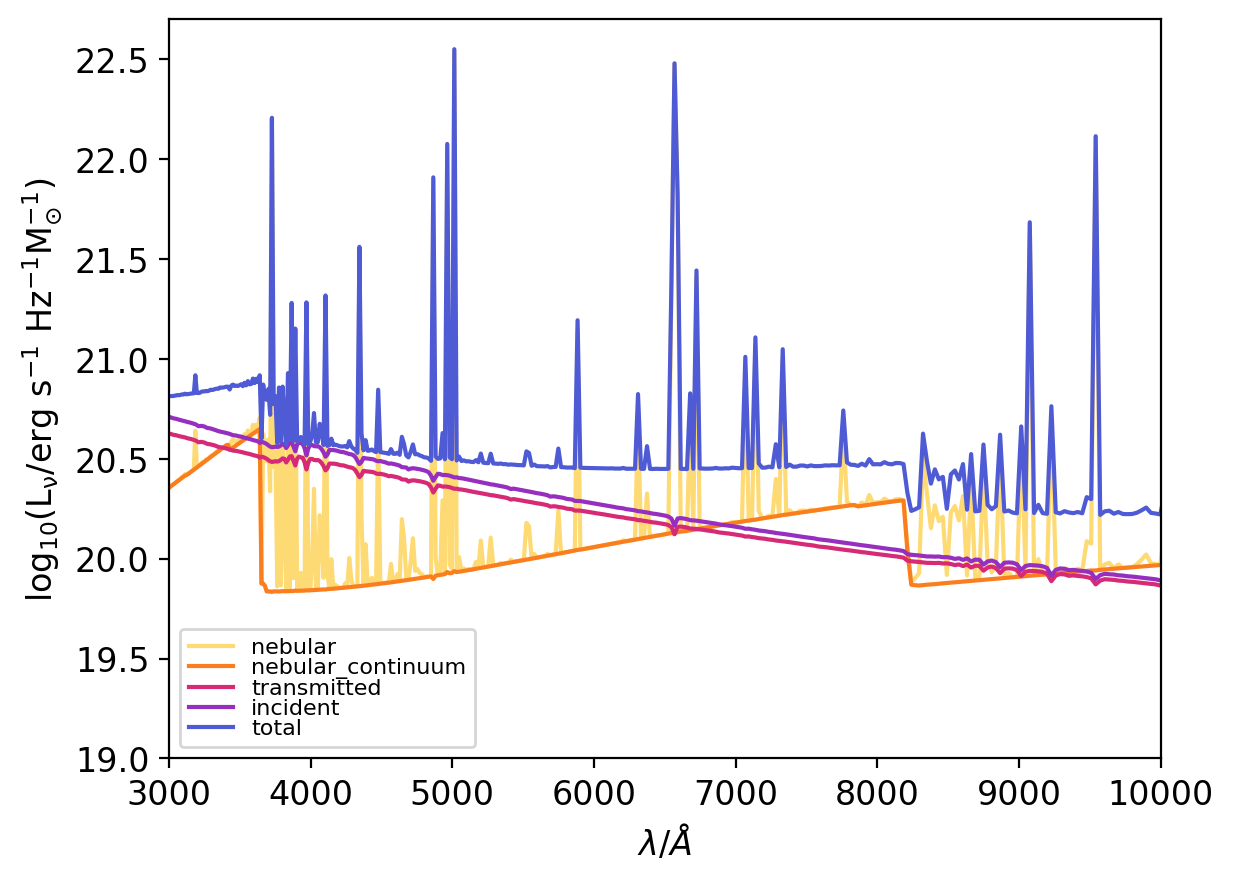

In [23]:
log10age = 6
Z = 0.02
grid_point = grid.get_grid_point((log10age, Z))

fig = plt.figure(figsize=(6.4, 4.8))

spectra_ids = ["nebular", "nebular_continuum", "transmitted", "incident", "total" ]
colors = ["#feda75", "#fa7e1e", "#d62976", "#962fbf", "#4f5bd5"]

for i, spectra_id in enumerate(spectra_ids):
    # get Sed object
    sed = grid.get_spectra(grid_point, spectra_id=spectra_id)
    plt.plot(
        sed.lam, np.log10(sed.lnu), lw=1.5, label=spectra_id, color=colors[i]
    )

plt.legend(fontsize=8, labelspacing=0.0)
plt.xlabel(r"$\lambda/\AA$")
plt.ylabel(r"$\rm log_{10}(L_{\nu}/erg\ s^{-1}\ Hz^{-1} M_{\odot}^{-1})$")

plt.ylim(bottom=19, top=22.7)
plt.xlim(left=3000, right=10000)

## Figure 4: Plot the spectra nice and big!

Text(0.5, 0, '$\\rm \\log_{10}(age/yr)$')

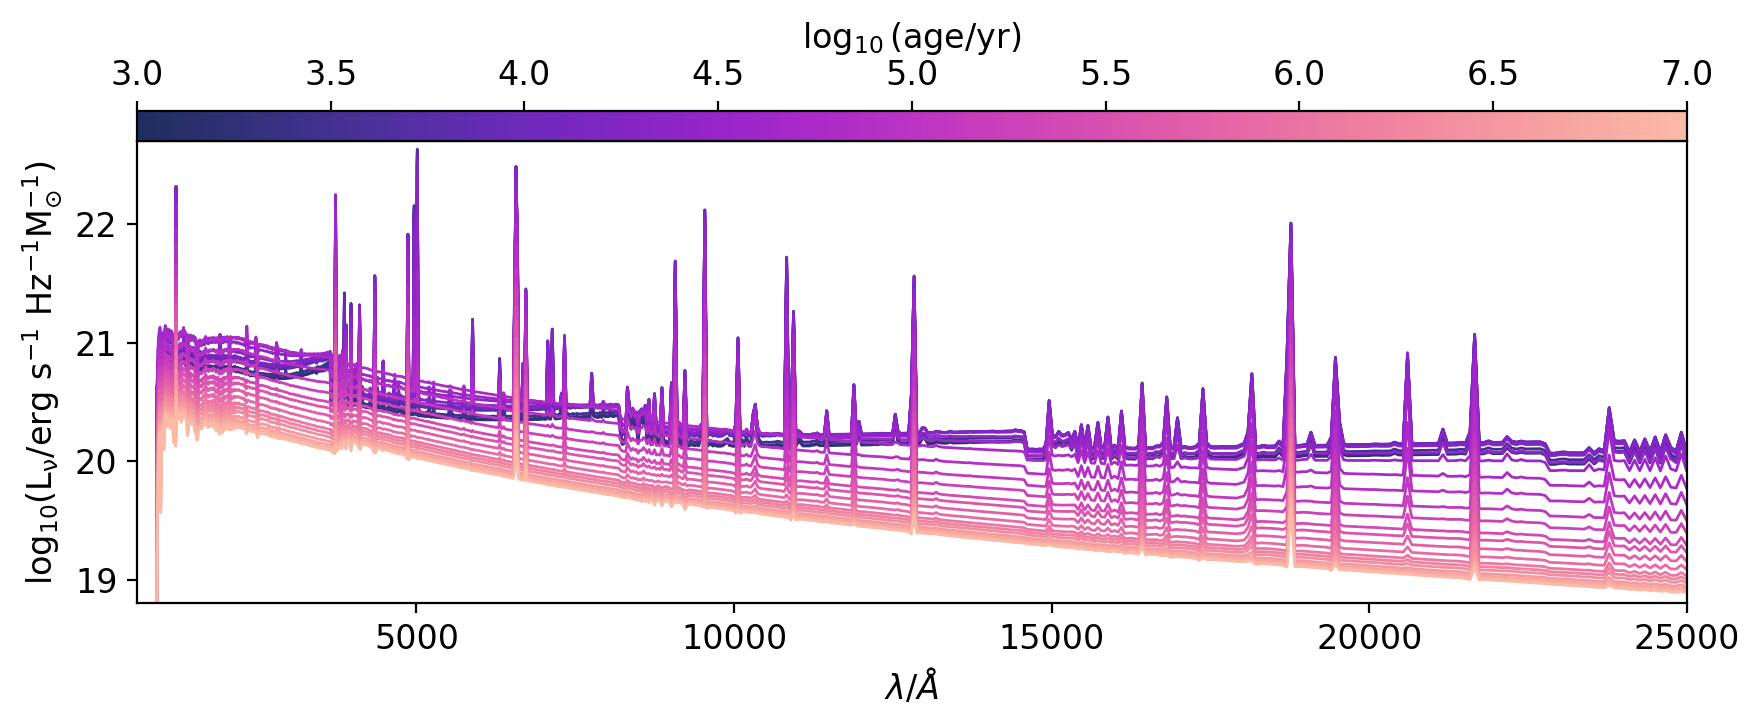

In [24]:
fig, ax = plt.subplots(figsize=(10,3))
norm = mpl.colors.Normalize(vmin=min(log10ages), vmax=max(log10ages))
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

Z = 0.02 
log10ages = grid.log10age

#for each age:
m = 0
for log10age in log10ages: 
    m = m + 1
    grid_point = grid.get_grid_point((log10age,Z))
    #Loop over the available spectra and plot Maraston:
    for spectra_id in ["total"]:
        # get Sed object
        sed = grid.get_spectra(grid_point, spectra_id=spectra_id)
        ax.plot(sed.lam, np.log10(sed.lnu), 
                 lw=1, 
                 label=f'log10age = {round(log10age,1)}',
                 color = cmap(m/len(log10ages)))


#plt.legend(labelspacing=0.0)
plt.xlim(left=600, right=25000)
plt.ylim(bottom=18.8, top=22.7)
plt.xlabel(r'$\lambda/\AA$')
plt.ylabel(r'$\rm log_{10}(L_{\nu}/erg\ s^{-1}\ Hz^{-1} M_{\odot}^{-1})$')

# Create colorbar axis
left = 0.125
bottom = 0.8
width = 0.775
height = 0.08
cax = fig.add_axes([left, bottom + height, width, 0.05])  # [left, bottom, width, height]
cbar = plt.colorbar(sm, cax=cax, orientation='horizontal')
cax.xaxis.tick_top()
cax.xaxis.set_label_position("top")
cax.set_xlabel(r"$\rm \log_{10}(age/yr)$")

## Figure 5: effect of varying U and Z on the nebular continuum

We need to now load a grid with fixed (rather than reference) ionization parameters

In [51]:
grid_dir = '../grids'

grid_name = 'maraston13_kroupa-max_age:7.0_cloudy-c23.01-sps-fixed-ionisation_parameter'
grid_fixed = Grid(grid_name, grid_dir=grid_dir, read_lines=True)

/home/sophienewman/.local/lib/python3.10/site-packages/unyt/array.py:1813: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


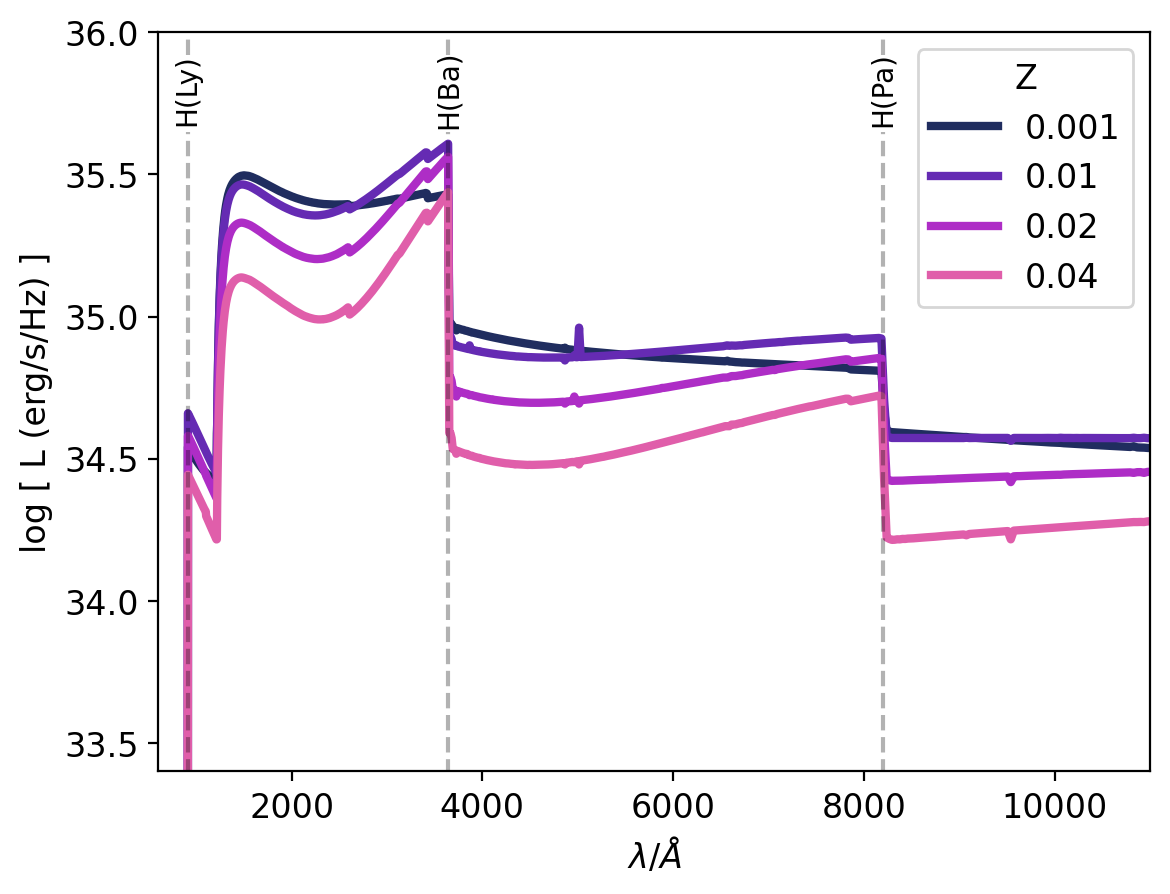

In [35]:
colors = cmr.take_cmap_colors('cmr.bubblegum', len(grid_fixed.metallicity), cmap_range=(0.1, 0.7), return_fmt='hex')

alphas = [0.2, 0.4, 0.6, 0.8]

U = 0.01
log10age = 6

for iZ, Z in enumerate(grid_fixed.metallicity):

    grid_point = grid_fixed.get_grid_point((log10age, Z, U))

    cont = grid_fixed.get_spectra(grid_point, spectra_id="nebular_continuum")

    cont_lum = cont.luminosity

    plt.plot(cont.lam, np.log10(cont_lum), c=colors[iZ], label=Z, lw=3) 


# Add line labels

line_label = ['H(Ly)', 'H(Ba)', 'H(Pa)']
line_wave = [910, 3644, 8200]

for i in np.arange(len(line_wave)):
    xpos = line_wave[i]  # x-value of the vertical line
    text = line_label[i]
    # First set of lines
    plt.vlines(x=xpos, ymin=33, ymax=35.65, color='black', linestyles="dashed", alpha=0.3)
    # Second set of lines with a small gap
    plt.vlines(x=xpos, ymin=35.92, ymax=36, color='black', linestyles="dashed", alpha=0.3)

    # Place text in between the two sets of lines
    plt.text(x=xpos, y=35.8, s=text, ha='center', va='center', rotation='vertical', fontsize=10)


plt.xlim(left=600, right=11000)
plt.ylim(bottom=33.4, top=36)

plt.ylabel('log [ L (erg/s/Hz) ]')
plt.xlabel(r"$\lambda/\AA$")
plt.legend(title='Z', loc='upper right')

/home/sophienewman/.local/lib/python3.10/site-packages/unyt/array.py:1813: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


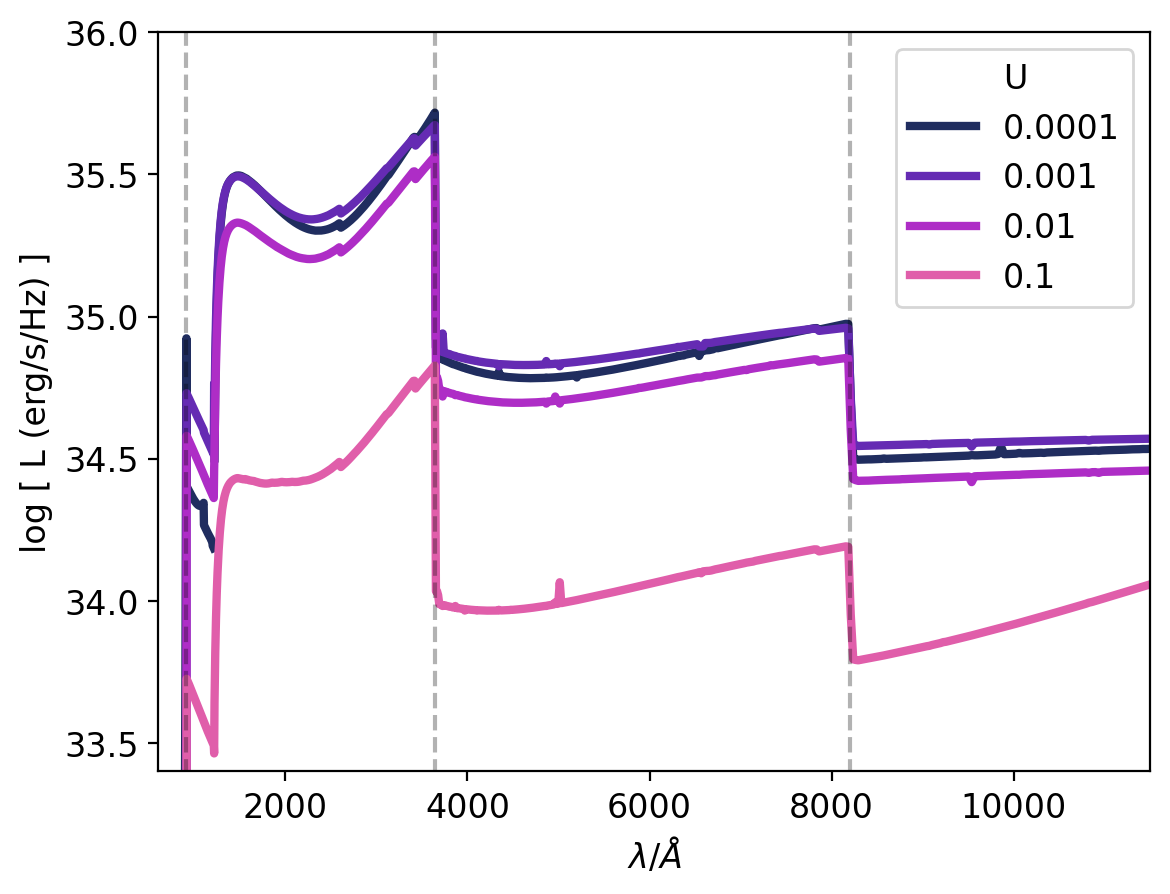

In [36]:
colors = cmr.take_cmap_colors('cmr.bubblegum', len(grid_fixed.ionisation_parameter), cmap_range=(0.1, 0.7), return_fmt='hex')

alphas = [0.2, 0.4, 0.6, 0.8]

Z = 0.02
log10age = 6

for iU, U in enumerate(grid_fixed.ionisation_parameter):

    grid_point = grid_fixed.get_grid_point((log10age, Z, U))

    cont = grid_fixed.get_spectra(grid_point, spectra_id="nebular_continuum")

    cont_lum = cont.luminosity

    plt.plot(cont.lam, np.log10(cont_lum), c=colors[iU], label=U, lw=3) 


# Add line labels

line_label = ['H(Ly)', 'H(Ba)', 'H(Pa)']
line_wave = [910, 3644, 8200]

for i in np.arange(len(line_wave)):
    xpos = line_wave[i]  # x-value of the vertical line
    
    plt.vlines(x=xpos, ymin=33, ymax=36, color='black', linestyles="dashed", alpha=0.3)

plt.xlim(left=600, right=11500)
plt.ylim(bottom=33.4, top=36)

plt.ylabel('log [ L (erg/s/Hz) ]')
plt.xlabel(r"$\lambda/\AA$")
plt.legend(title='U', loc='upper right')

## Figure 6: Fractional contribution to the total luminosity from stars, the nebula continuum, and line emission

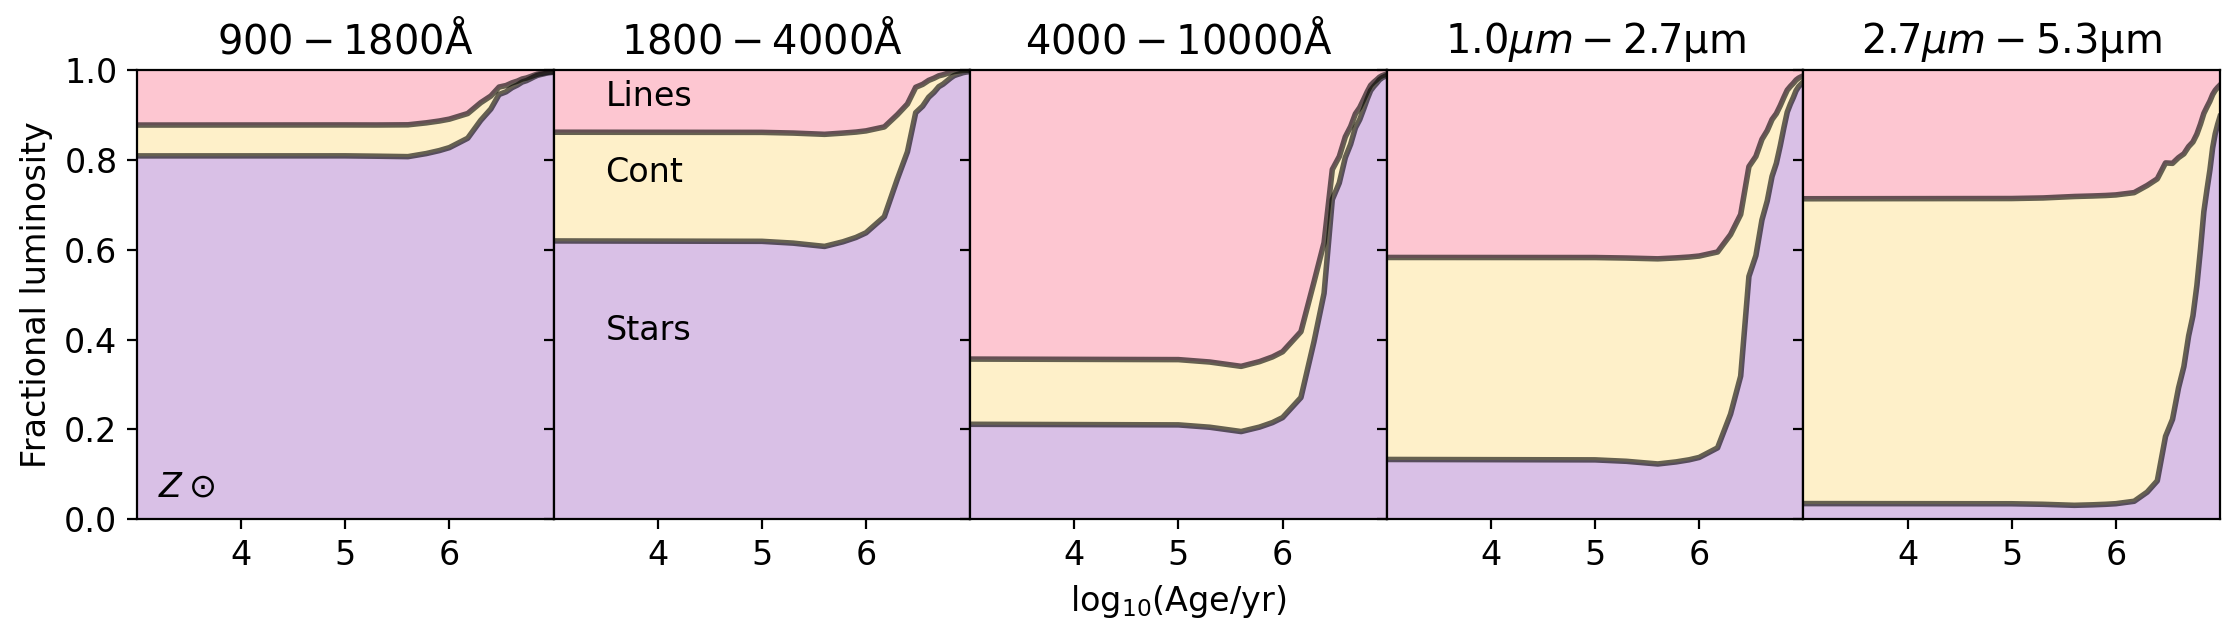

In [43]:
colors = cmr.take_cmap_colors('cmr.sapphire', len(grid.metallicity), cmap_range=(0.7, 1.0), return_fmt='hex')

fig, axes = plt.subplots(1, 5, figsize=(11,3), sharex=True, sharey=True)

U = 0.01
Z = 0.02

wavelength_ranges = [[900 * Angstrom, 1800 * Angstrom],
                     [1800 * Angstrom, 4000 * Angstrom],
                     [4000 * Angstrom, 10000 * Angstrom],
                     [1 * um, 2.7 * um],
                     [2.7 * um, 5.3 * um] ]

for ix, ax in enumerate(axes) :

    frac_cont = []
    frac_line = []
    frac_star = []

    for ia, log10age in enumerate(grid.log10age):

        grid_point = grid.get_grid_point((log10age, Z, U))

        # get our SEDs
        cont = grid.get_spectra(grid_point, spectra_id="nebular_continuum")
        line = grid.get_spectra(grid_point, spectra_id="nebular")
        star = grid.get_spectra(grid_point, spectra_id="transmitted")
        total = grid.get_spectra(grid_point, spectra_id="total")

        # integrate this over wavelength
        cont_lum = cont.measure_window_lnu( wavelength_ranges[ix] )
        line_lum = line.measure_window_lnu( wavelength_ranges[ix] )
        star_lum = star.measure_window_lnu( wavelength_ranges[ix] )
        total_lum = total.measure_window_lnu( wavelength_ranges[ix] )

        frac_cont.append( cont_lum / total_lum )
        frac_line.append( line_lum / total_lum )
        frac_star.append( star_lum / total_lum )

    # lines to fill between
    line_line = np.array(frac_line) + np.array(frac_star)
    cont_line = np.array(frac_cont) + np.array(frac_star)
    star_line = frac_star

    alpha = 0.9

    # plot black lines
    ax.plot(log10ages, cont_line, linewidth=2, color='black', alpha=0.6)
    ax.plot(log10ages, star_line, linewidth=2, color='black', alpha=0.6)

    # line
    ax.fill_between(log10ages, line_line, cont_line, color='#fdc0cc', linewidth=0, alpha=alpha)

    # continuum
    ax.fill_between(log10ages, cont_line, star_line, color='#feefc4', linewidth=0, alpha=alpha)

    # star
    ax.fill_between(log10ages, star_line, np.linspace(0,0,len(star_line)), color='#d5b9e4', linewidth=0, alpha=alpha)

axes[0].set_ylabel('Fractional luminosity')
axes[2].set_xlabel(r"log$_{10}$(Age/yr)")

# Label contributions
axes[1].text(3.5, 0.4, 'Stars')
axes[1].text(3.5, 0.75, 'Cont')
axes[1].text(3.5, 0.92, 'Lines')

# Label wavelength ranges
wav_x = 3.1
wav_y = 0.06
axes[0].set_title(r'$900-1800 \rm \AA$')
axes[1].set_title(r'$1800-4000 \rm \AA$')
axes[2].set_title(r'$4000-10000 \rm \AA$')
axes[3].set_title(r'$1.0\mu m-2.7\rm \mu m$')
axes[4].set_title(r'$2.7\mu m-5.3\rm \mu m$')

axes[0].text(3.2, 0.05, r'$Z\odot$')
     

plt.ylim(bottom=0, top=1)
plt.xlim(left=log10ages[0], right=log10ages[-1])
plt.xticks([4,5,6])

plt.tight_layout(pad=0)  # Set padding between subplots to zero
plt.subplots_adjust(wspace=0)

## Figure 7: effect of varying Z on line luminosities

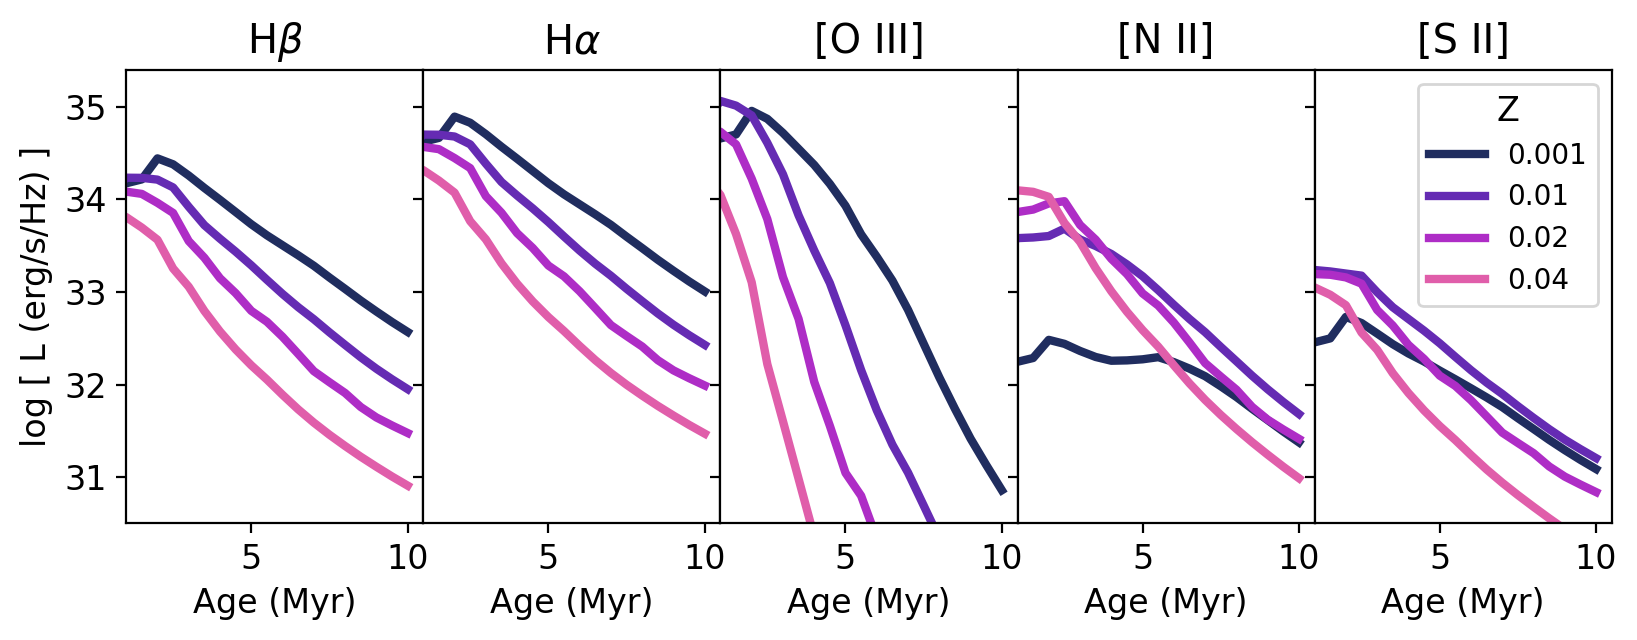

In [41]:
colors = cmr.take_cmap_colors('cmr.bubblegum', len(grid_fixed.metallicity), cmap_range=(0.1, 0.7), return_fmt='hex')

fig, axes = plt.subplots(1, 5, figsize=(8, 3), sharey=True)  # 1 row, 5 columns

line_ids = ['H 1 4861.32A', 'H 1 6562.80A', 'O 3 5006.84A', 'N 2 6583.45A', 'S 2 6730.82A']
line_label = [r'H$\beta$', r'H$\alpha$', '[O III]', '[N II]', '[S II]']

U = 0.01
iU = 2

for line, ax in enumerate(axes):
    ax.set_title(line_label[line])

    for iZ, Z in enumerate(grid_fixed.metallicity):

        x = []
        y = []
        line_lum = []
        
        for ia, log10age in enumerate(grid.log10age):
            grid_point = (ia, iZ, iU) 

            sed_incident = grid_fixed.get_spectra(grid_point, spectra_id="incident")
            sed_total = grid_fixed.get_spectra(grid_point, spectra_id="total")

            #get luminosity of line 
            wanted_line = grid_fixed.get_line(grid_point, line_ids[line])
            line_lum.append( wanted_line.luminosity )
            

        ax.plot(10**(grid_fixed.log10age)/1e6, np.log10(line_lum), c=colors[iZ], label=Z, lw=3) 
        ax.set_ylim(top = 35.4, bottom=30.5)
        ax.set_xlim(left=1)
        ax.set_xlabel('Age (Myr)')

plt.tight_layout()
axes[0].set_ylabel('log [ L (erg/s/Hz) ]')


legend_elements = [Line2D([0, 1], [0, 1], linestyle='-', lw=3, color=colors[0], label='0.001'),
                   Line2D([0, 1], [0, 1], linestyle='-',  lw=3, color=colors[1], label='0.01'),
                   Line2D([0, 1], [0, 1], linestyle='-',  lw=3, color=colors[2], label='0.02'),
                   Line2D([0, 1], [0, 1], linestyle='-',  lw=3, color=colors[3], label='0.04')
]

# add to legend element for line of ls '--'

axes[4].legend(title='Z', handles=legend_elements, loc='upper right', fontsize=10)

plt.tight_layout(pad=0)  # Set padding between subplots to zero
plt.subplots_adjust(wspace=0)

## Figure 8: effect of varying U on line luminosities

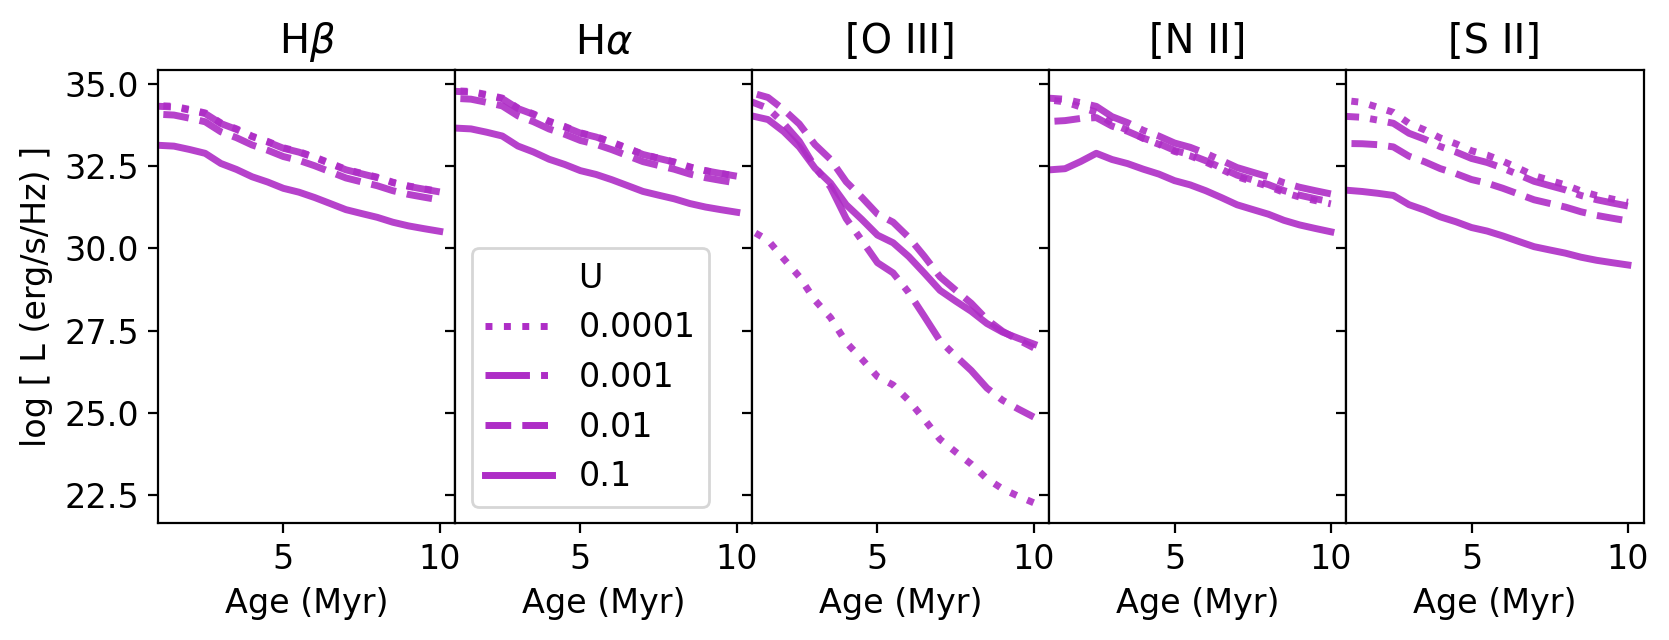

In [42]:
colors = cmr.take_cmap_colors('cmr.bubblegum', len(grid_fixed.metallicity), cmap_range=(0.1, 0.7), return_fmt='hex')

fig, axes = plt.subplots(1, 5, figsize=(8, 3), sharey=True)  # 1 row, 5 columns

line_ids = ['H 1 4861.32A', 'H 1 6562.80A', 'O 3 5006.84A', 'N 2 6583.45A', 'S 2 6730.82A']
line_label = [r'H$\beta$', r'H$\alpha$', '[O III]', '[N II]', '[S II]']

line_styles = [':', '-.', '--', '-']

iZ = 2
Z = 0.02

for line, ax in enumerate(axes):
    ax.set_title(line_label[line])

    for iU, U in enumerate(grid_fixed.ionisation_parameter):

        x = []
        y = []
        line_lum = []
        
        for ia, log10age in enumerate(grid_fixed.log10age):
            grid_point = (ia, iZ, iU) 

            sed_incident = grid_fixed.get_spectra(grid_point, spectra_id="incident")
            sed_total = grid_fixed.get_spectra(grid_point, spectra_id="total")

            #get luminosity of line 
            wanted_line = grid_fixed.get_line(grid_point, line_ids[line])
            line_lum.append( wanted_line.luminosity )
            
        ls = line_styles[iU]

        ax.plot(10**(grid_fixed.log10age)/1e6, np.log10(line_lum), c=colors[iZ], label=Z, ls=ls, lw=2.5, alpha=0.9) 
        ax.set_xlim(left=1)
        #ax.set_ylim(top = 35, bottom=25)
        #ax.set_ylim(top = 42, bottom=36)
        ax.set_xlabel('Age (Myr)')

plt.tight_layout()
axes[0].set_ylabel('log [ L (erg/s/Hz) ]')


legend_elements = [Line2D([0, 1], [0, 1], linestyle=':', lw=2.5, color=colors[2], label='0.0001'),
                   Line2D([0, 1], [0, 1], linestyle='-.', lw=2.5, color=colors[2], label='0.001'),
                   Line2D([0, 1], [0, 1], linestyle='--', lw=2.5, color=colors[2], label='0.01'),
                   Line2D([0, 1], [0, 1], linestyle='-', lw=2.5, color=colors[2], label='0.1')
]

# add to legend element for line of ls '--'

axes[1].legend(title='U', handles=legend_elements, loc='lower left')

plt.tight_layout(pad=0)  # Set padding between subplots to zero
plt.subplots_adjust(wspace=0)

## Figure 9: effect of varying hydrogen density on line luminosities

First load the grid with varying hydrogen densities:

In [45]:
grid_dir = '../grids'

grid_name = 'maraston13_kroupa-max_age:7.0_cloudy-c23.01-sps-fixed-hydrogen_density'
grid = Grid(grid_name, grid_dir=grid_dir, read_lines=True)

and now we can plot these!

/home/sophienewman/miniconda3/envs/synth/lib/python3.10/site-packages/synthesizer/grid.py:780: FutureWarning: Line objects should be created with a string id, not a list or tuple. This will be removed in a future version.
  Line(


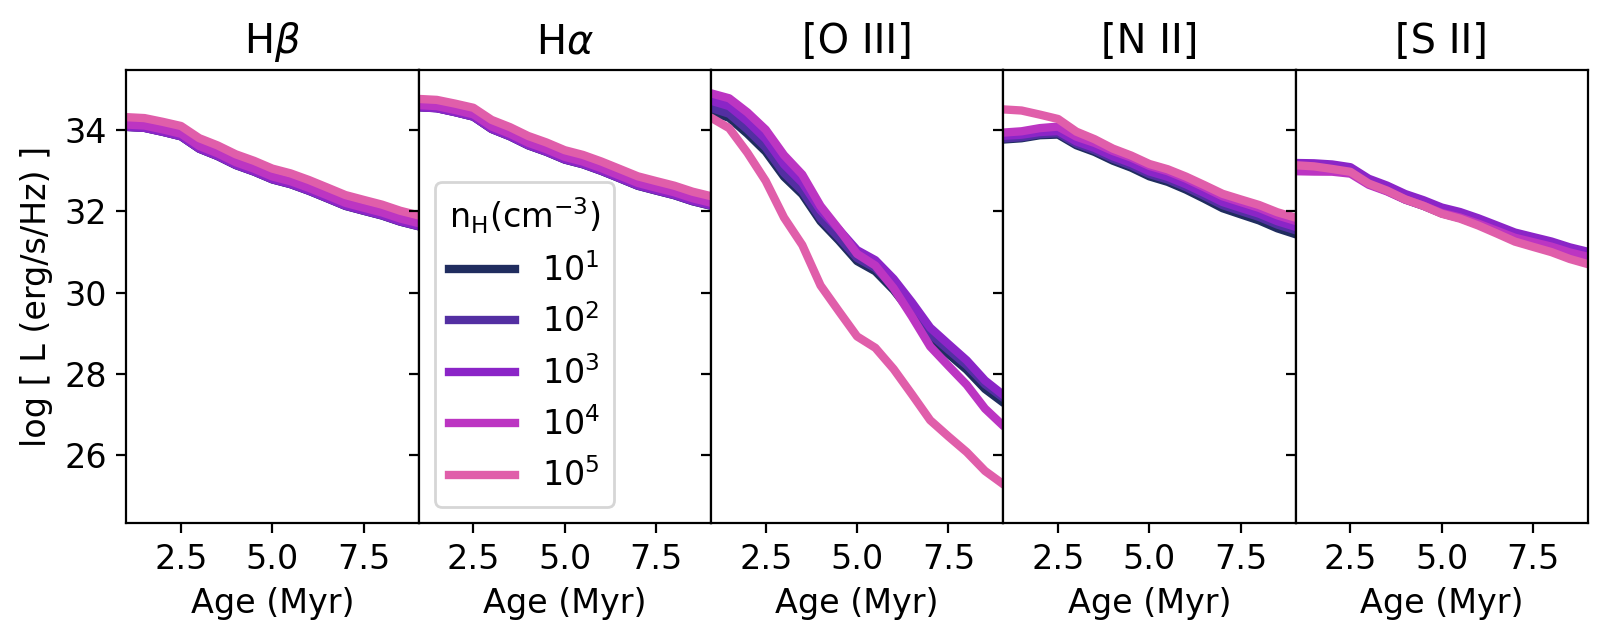

In [46]:
colors = cmr.take_cmap_colors('cmr.bubblegum', len(grid.hydrogen_density), cmap_range=(0.1, 0.7), return_fmt='hex')

fig, axes = plt.subplots(1, 5, figsize=(8,3), sharey=True)  # 1 row, 5 columns

line_ids = ['H 1 4861.32A', 'H 1 6562.80A', 'O 3 5006.84A', 'N 2 6583.45A', 'S 2 6730.82A']
line_label = [r'H$\beta$', r'H$\alpha$', '[O III]', '[N II]', '[S II]']

alphas = [0.1, 0.2, 0.4, 0.6, 0.8]

# solar Z
iZ = 2

for line, ax in enumerate(axes):
    ax.set_title(line_label[line])

    for iN, N in enumerate(grid.hydrogen_density):

        x = []
        y = []
        lums = []
        for ia, log10age in enumerate(grid.log10age):
            grid_point = (ia, iZ, iN)

            #get luminosity of line 
            wanted_line = grid.get_line(grid_point, line_ids[line])
            lums.append( wanted_line.luminosity )
        
        ax.plot(10**(grid.log10age)/1e6, np.log10(lums), c=colors[iN], lw=3, label=f'$10^{{{int(np.log10(N))}}}$') 
        ax.set_xlim(left=1,right=9)
        #ax.set_ylim(top = 10.6, bottom=6)
        ax.set_xlabel('Age (Myr)')

plt.tight_layout()
axes[0].set_ylabel('log [ L (erg/s/Hz) ]')

axes[1].legend(title=r'$\rm n_H (cm^{-3})$', loc='lower left')

plt.tight_layout(pad=0)  # Set padding between subplots to zero
plt.subplots_adjust(wspace=0)

## The next notebook!

In the next notebook, we will compare our results to SDSS and JADES data!